# Introduction to Manifold Learning

-----

Often, the fundamental goal of machine learning is to gain insight into a particular data set. With feature selection and dimensional reduction, we have identified methods to find the most relevant features in a data set, or to create new features that retain the majority of the signal in a data set. These techniques allow for a smaller set of features to be used in machine learning applications, ideally with no or little reduction in accuracy. 

In this notebook, we introduce a different technique, known as [manifold learning][wml], where a high dimensional data set is reduced down to two or three dimensions, which simplifies both analysis, and perhaps more importantly visualization (and thus understanding). These techniques all assume that the data, in high dimensions, occupy some non-linear manifold, which can be mapped via non-linear transformations to a much lower dimensional space. How the different algorithms perform this transformation vary, and the results also vary both in precision and the computational time they require. However, the results can often be dramatic and enable new insights into data sets that seem too large to visualize in any meaningful way.


-----

[wml]: https://en.wikipedia.org/wiki/Nonlinear_dimensionality_reduction

## Table of Contents

[Initialization](#Initialization)

[PCA Demonstration](#PCA-Demonstration)

[Locally Linear Embedding](#Locally-Linear-Embedding)

[Multidimensional Scaling](#Multidimensional-Scaling)

[Isometric Mapping](#Isometric-Mapping)

[t-SNE](#t-SNE)

[Feature Unions](#Feature-Unions)

-----

Before proceeding with the rest of this notebook, we first have our standard notebook setup code.

-----

In [1]:
# Set up Notebook

%matplotlib inline

# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# We do this to ignore several specific Pandas warnings
import warnings
warnings.filterwarnings("ignore")

# Set global figure properties
import matplotlib as mpl
mpl.rcParams.update({'axes.titlesize' : 20,
                     'axes.labelsize' : 18,
                     'legend.fontsize': 16})

# Set default seaborn plotting style
sns.set_style('white')

# Some cells take a while to run, so we will time them
from time import time

-----

[[Back to TOC]](#Table-of-Contents)

## Initialization

In this section, we first define a function that will be used to visualize the results of the different manifold learning algorithms. Next, we load the handwritten digit data, which is the data we will use to demonstrate manifold learning in this notebook. Since these data have sixty-four dimensions, they provide a nice example on which to apply these algorithms. Finally, we globally define the number of neighbors that will be used to perform the manifold learning. Changing this value, will demonstrate the impact the neighbor-space will have on each individual algorithm.

The plotting function defined in the following Code cell, `plot_digits`, generates a two-dimensional visualization of the output from the manifold learning algorithm. Thus, the plots will show how a specific algorithm projected the sixty-four dimensions (in the handwritten digit data) down to the two dimensions used in the visualization. The plot color codes each class uniquely, and also over-plots the class label at the mean position of all of the class instances (i.e., at the center of the distribution of colored points). The rest of the function code decorates the plot with a legend, title, and axes labels, before removing the right and top spines.

-----

In [2]:
# We select a specific color pallete from Seaborn
# with ten shades.
from matplotlib.colors import ListedColormap
my_cmap = ListedColormap(sns.color_palette("Paired", 10))

# Plot projected digit data
def plot_digits(x, y, type, num_types = 10):
    # Create Figure and axes
    fig, axs = plt.subplots(figsize=(10, 10))
    
    # Plot each class separately
    for idx in range(num_types):
        xx = x[(y == idx)]
        
        # Plot the instances of each class in projected dimensions
        axs.scatter(xx[:, 0], xx[:, 1], s=25, 
                    color=my_cmap(idx), alpha=0.75,
                    label=f'{idx}')
        
        # Compute class centers and mark with text label
        xc, yc = np.mean(xx, axis=0)
        axs.text(xc, yc, str(idx), weight='normal', size=16, 
                 backgroundcolor='white')

        # Decorate plot with legend and labels.
        axs.legend(fontsize='medium', bbox_to_anchor=(1.05, 1.05))

        axs.set(title=f'(Digit Data) {type}',
                xlabel='First Component',
                ylabel='Second Component')
        
        # Clean plot
        axs.spines['top'].set_visible(False)
        axs.spines['right'].set_visible(False)
        sns.despine(offset=10)

-----

### Handwritten Digit Data

Manifold learning is primarily applied to high dimensional data sets, often reducing the data to two-dimensions for simple visualization. As a result, we load the handwritten digit data in the following Code cell. These data consist of over 1,700 instances that each have sixty-four features. The following Code cell also displays an example from each class, zero through nine, to help understand how these algorithms operate when they project the sixty-four dimensions down to the two dimensions used throughout this notebook.

-----

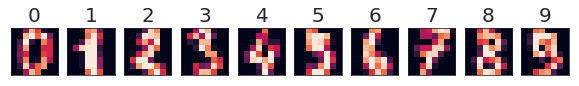

In [3]:
import sklearn.datasets as ds

# Load the digits data
digits = ds.load_digits()
    
# Now lets get the data and labels
x = digits.data
y = digits.target
images = digits.images

# Create figure and axes (we plot ten images side-by-side)
fig, axs = plt.subplots(figsize=(10,8), nrows=1, ncols=10)

for idx in np.arange(10):
        
    # We want square images
    axs[idx].set_aspect('equal')
        
    # Now show the images, by default pixels are shown as white on black.
    # To show black on white, reverse colormap: cmap=plt.cm.gray_r
    # To smooth pixelated images: interpolation='nearest'
    axs[idx].imshow(images[idx], interpolation='nearest')
        
    # No tick marks for small plots
    axs[idx].set_xticks([]) ; axs[idx].set_yticks([])
    
    # Label number        
    axs[idx].set_title(y[idx])

-----

Many of the manifold learning algorithms operate by maintaining relationships between neighboring data. Thus, we often need to specify a number of neighbors hyperparameter. We specify this value globally for the notebook in the following Code cell. Changing this value here and rerunning the entire notebook will implement the global change.

-----

In [4]:
# Set number of neighbors for manifold learning algorithms
num_nbrs = 25

-----

[[Back to TOC]](#Table-of-Contents)

## PCA Demonstration

Before introducing manifold learning, we first compute the first two principal components for these data and produce a visualization of the class distribution in these two dimensions. This visualization serves as a baseline against which the manifold learning techniques can be compared. In this plot, we see that classes zero, four, and six are somewhat separated from the other classes, and the remaining classes are intermixed with other classes in an intuitive manner. For example, the numbers one and seven often look similar, and the plot below shows these two classes are intermixed. Likewise with classes two, three, five, eight and nine, especially when only the top two principal components are retained.

-----

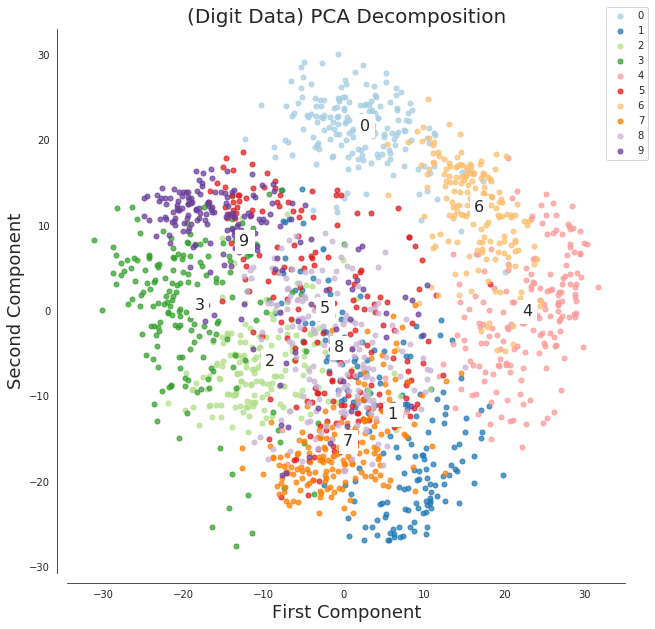

In [5]:
# Principal Component Analysis
from sklearn.decomposition import PCA
x_pca = PCA(n_components=2, random_state=23).fit_transform(x)

# Plot two component distribution
plot_digits(x_pca, y, 'PCA Decomposition')

-----

[[Back to TOC]](#Table-of-Contents)

## Locally Linear Embedding 

The [locally linear embedding (LLE)][wlle] algorithm effectively models a data set with many local linear approximations. When the data are highly non-linear, the local area is made small, so that the approximation is valid only over a small region. Thus, the approximation depends on the local neighborhood around any given point. This neighborhood can be defined by a specific distance or by simply choosing a pre-defined number of neighbors.

The scikit learn library provides an implementation of this algorithm with the [`LocallyLinearEmbedding`][sklle] estimator in the `manifold` module. Key hyperparameters for this algorithm include
- `n_neighbors`: the number of neighbors that define the local area, default is five.
- `n_components`: the number of components to use for the final manifold, default is two.
- `method`: the specific form of LLE to be used to generate the new manifold, the default is the standard LLE algorithm.

The following Code cell demonstrates LLE being applied to the handwritten digit data, in this case only the `n_neighbors` hyperparameter is changed from a default value (from five to our notebook global value defined earlier). The resultant figure looks quite different from the PCA figure displayed earlier, with long trails for the classes zero, six, and seven, along with a clumping of the rest of the classes in the center. As the various hyperparameters are changed, this manifold representation will also change, however, the nature of the digit data does not necessarily map well onto the capabilities of this algorithm (you should communicate with the instructor if you do find a set of hyperparameters that produces a nice class separation).

-----
[wlle]: https://en.wikipedia.org/wiki/Nonlinear_dimensionality_reduction#Locally-linear_embedding
[sklle]: http://scikit-learn.org/stable/modules/generated/sklearn.manifold.LocallyLinearEmbedding.html

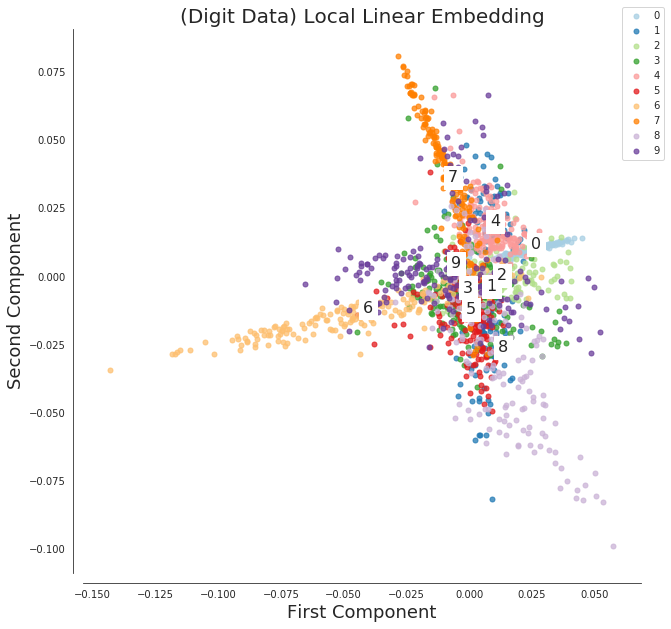

In [6]:
from sklearn.manifold import LocallyLinearEmbedding

# Perform LLE manifold learning
t_lle = LocallyLinearEmbedding(num_nbrs, n_components=2, random_state=23,
                               method='standard').fit(x)

# Plot two component distribution
plot_digits(t_lle.embedding_, y, 'Local Linear Embedding')

-----

[[Back to TOC]](#Table-of-Contents)

## Multidimensional Scaling

[Multidimensional scaling (MDS)][wmds] employs linear approximations to a data set to 
preserve similarities between points when transforming the data to a lower dimensional manifold. The similarities can be distances, and when the space is Euclidean, this technique becomes standard PCA. However, the distances can employ any metric, and this technique can, therefore, produce complex non-linear transformation. Furthermore, the similarities can involve quantities other than distance.

This algorithm is implemented in the scikit learn library by the [`MDS`][skmds] estimator in the `manifold` module. Key hyperparameters include
- `n_components`: number of components to use in final manifold, default is two.
- `n_init`: the number of times the underlying algorithm will be run, the best result over all runs is used to perform the transformation.
- `dissimilarity`: the metric to use when computing the similarity (or dissimilarity) of points. This value can be `euclidean`, which computes pairwise Euclidean distances, or `precomputed`, where the similarity measures are precomputed and passed into the estimator.

The following Code cell performs MDS on the handwritten digit data set. Note how the manifold is distinctly different than the LLE example, as the data re distributed more homogeneously (we used a Euclidean distance by default, hence the result is constrained in the circular geometry. The classes zero, two, three, four, six, seven, eight, and nine are fairly well confined, although the do bleed into each other on occasion. For example, four and six overlap, which is reasonable since their image representations are often similar. Likewise, for classes two and seven. On the other hand, classes one and five have distinct sub-groups (notice how the label is not centrally located with the points belonging to each class for these two classes). This seems to indicate that class one is confused with classes two, four, and five, while class five is confused with class one and nine with these particular set of hyperparameters.

-----
[wmds]: https://en.wikipedia.org/wiki/Multidimensional_scaling
[skmds]: http://scikit-learn.org/stable/modules/generated/sklearn.manifold.MDS.html

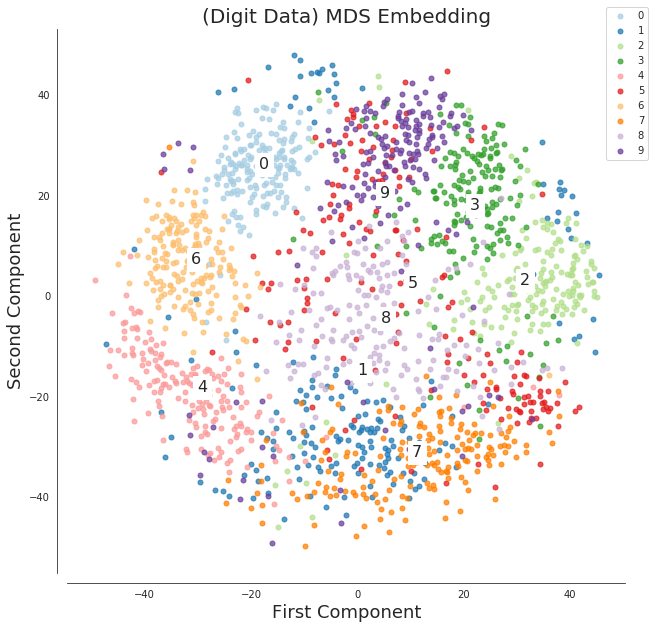

In [7]:
from sklearn.manifold import MDS

# Perform MDS manifold learning
x_mds = MDS(n_components=2, n_init=1, max_iter=250).fit(x)

# Plot two component distribution
plot_digits(x_mds.embedding_, y, 'MDS Embedding')

-----
[[Back to TOC]](#Table-of-Contents)

## Isometric Mapping

The [Isometric mapping (Isomap)][wi] algorithm is a variant of the MDS algorithm, and computes a transformation that produces a manifold that generates a graph connecting neighbors. This graph represents the neighborhoods of all points in the original data space and is used to find the shortest paths between points. The MDS algorithm can be applied to the shortest paths to produce a robust manifold transformation.

This algorithm is implemented in the scikit learn library by the [`Isomap`][skiso] estimator in the `manifold` module. Key hyperparameters include
- `n_neighbors`: the number of nearby points that define the neighborhood, default is five.
- `n_components`: number of components to use in final manifold, default is two.
- `path_method`: the technique used to find the shortest path in the neighborhood graph, default is `auto`, which attempts to determine the best technique automatically.

The following Code cell applies the Isomap algorithm to the handwritten digit data. The resulting manifold, with our default hyperparameters, actually separates the different classes quite well. The zero, two, three, four, six, seven, and nine classes are fairly well contained, and the one, five, and eight classes are also distinguishable, albeit with some mixing. The one and five classes are less well separated, however, they are more compactly distributed than with the MDS algorithm alone. This example demonstrates the utility of the Isomap algorithm, which can easily produce a nice manifold for high dimensional data. 

-----

[wi]: https://en.wikipedia.org/wiki/Isomap
[skiso]: http://scikit-learn.org/stable/modules/generated/sklearn.manifold.Isomap.html

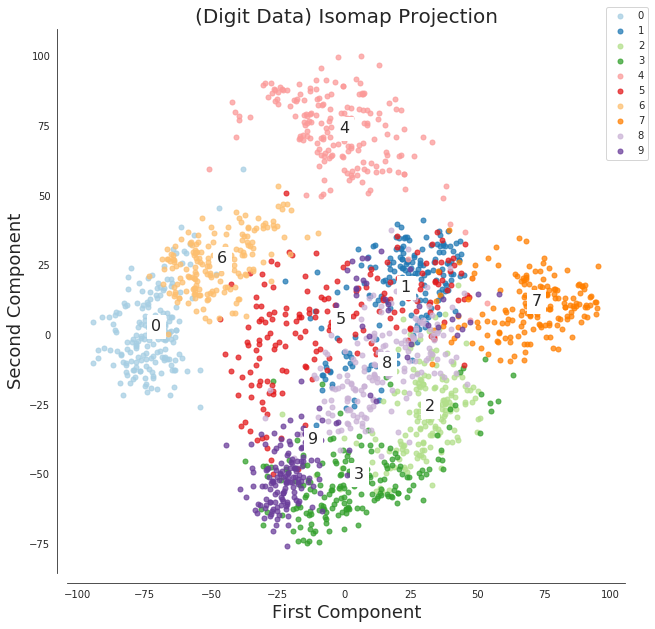

In [8]:
from sklearn.manifold import Isomap

# Perform Isomap manifold learning
x_iso = Isomap(num_nbrs, n_components=2).fit(x)

# Plot two component distribution
plot_digits(x_iso.embedding_, y, 'Isomap Projection')

-----

[[Back to TOC]](#Table-of-Contents)

## t-SNE

The [t-distributed stochastic neighbor embedding (t-SNE)][wt] algorithm generates a manifold where similar points are closely mapped and dissimilar points are more distantly mapped. This is accomplished in a two-phase process. First, the algorithm generates a probability distribution that ties the probability to the similarity of the points (e.g., via a Euclidean distance metric). Second, the same process is repeated for the low dimensional space, and the relative entropy between these two distributions is minimized. 


This algorithm is implemented in the scikit learn library by the [`TSNE`][skt] estimator in the `manifold` module. Key hyperparameters include
- `n_components`: the dimension of the generated manifold, default is two.
- `perplexity`: the number of points used to compute the perplexity, which quantifies how well a probability distribution matches the points, default is thirty.
- `early_exaggeration`: controls how clusters that exist in the original space will be distributed in the manifold, default is twelve.
- `n_iter`: the maximum number of iterations for the optimization process, default is 1000.

The following Code cell applies the t-SNE algorithm to the handwritten digit data. The resulting manifold, is quite amazing. The digit data are generally tightly clustered, with classes one, two, three, four, five, seven, and eight all being confined to well defined (and separated) groups. Classes zero, six, and nine are, with these hyperparameters, still distributed, but now the points in these classes are still in sub-clumps. From this visualization it might seem odd to spend any time on other algorithms as this visualization shows how powerful t-SNE can be in creating a two- (or three-) dimensional manifold from high dimensional data. While this is generally true, this algorithm is computationally expensive, which you might have seen when running the notebook, and thus often follows the application of PCA or another technique that provides guidance on the optimal set of hyperparameters.

-----
[wt]: https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding
[skt]: http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

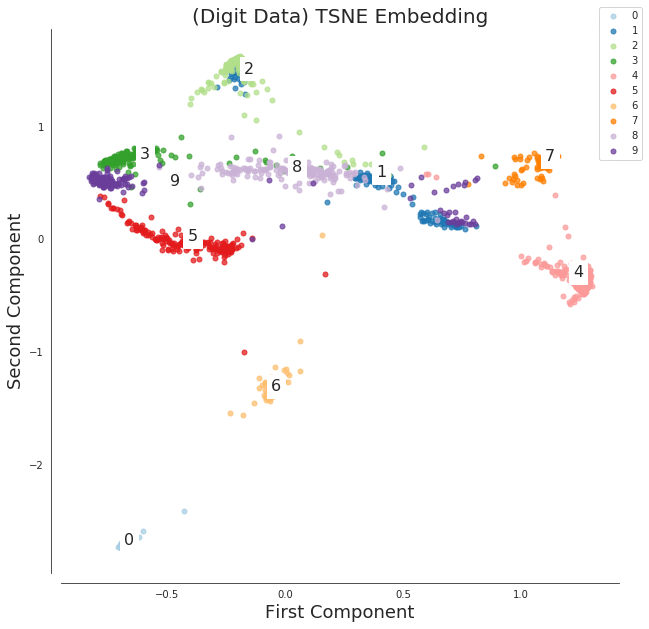

In [9]:
from sklearn.manifold import TSNE

x_tsne = TSNE(n_components=2,  
              perplexity=50, n_iter=250, random_state=23).fit(x)

# Plot two component distribution
plot_digits(x_tsne.embedding_, y, 'TSNE Embedding')

-----

<font color='red' size = '5'> Student Exercise </font>

In the preceding cells, you have tried different manifold learning techniques, including LLE, Isomap, and t-SNE. Now that you have seen how these techniques can be applied to the handwritten digit data set, try changing the following hyperparameters to see how they impact the performance.

1. Change the `n_init` to a higher value for LLE.
2. Change the global number of neighbors, both higher and lower. How do the figures change?
3. Change the `max_iter` to a much higher value for MDS.
4. Change the perplexity for t-SNE higher and lower.
3. Change the `n_iter` to a much higher value for t-SNE.


-----

[[Back to TOC]](#Table-of-Contents)

## Feature Unions

There are a number of different techniques that can be used to select the best set of features with which to perform machine learning. In some cases, such as the manifold learning techniques presented in this notebook, these techniques stand on their own, but make new features that generally do not provide physical insight into the learning algorithm. On the other hand, we can employ feature selection such as selecting the k best features or the best percentage of features, which prunes the original data dimensionality to a smaller number of features that ideally contain most of the signal. 

Some of these techniques are model dependent, thus we can employ different models to generate the _best_ set of features in a more general sense (or find features that are *always* important). To combine sets of features identified with different techniques, the scikit learn library provides the [`FeatureUnion`][skfu] transformer, which combines other transformers, by using a pipeline, to create a union of the features selected by the different transformers in the pipeline. 

The following Code cells demonstrate how the feature union can be used to produce a set of features from different feature selection techniques. First, the digit data are separated into training and testing samples. In the second Code cell, we create the different feature selection estimators, and the feature union pipeline that combines them into a new transformer. The third Code cell creates a new pipeline that combines the feature union with a new classifier. This pipeline will be used to perform hyperparameter tuning via a cross-validation grid search.

-----

[skfu]: http://scikit-learn.org/stable/modules/pipeline.html#feature-union

In [10]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = \
    train_test_split(x, y, test_size = 0.25, 
                     stratify=y, random_state=23)

In [11]:
from sklearn.pipeline import FeatureUnion
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SelectFromModel

from sklearn.ensemble import ExtraTreesClassifier

fu = FeatureUnion([("sfm", SelectFromModel(ExtraTreesClassifier(random_state=23))),
                   ("skb", SelectKBest())])

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC

# Feature selection as part of a pipeline

pl = Pipeline([('pfu', fu),
               ('svc', LinearSVC(random_state=23))])

-----

With the scikit learn feature union and machine learning pipeline created, the next Code cell performs the cross-validation grid search. This process will not only determine the best linear SVC hyperparameter (i.e., the `C` value), but also the best value for `k` in the select k best transformer, and the `threshold` for the select form model feature selection transformer. At the end, we display the compute time and the best cross-validation score.

-----

In [13]:
from sklearn.model_selection import GridSearchCV

start = time()

pg = dict(pfu__sfm__threshold=['0.1 * mean', '0.25 * mean', '0.5 * mean', '0.75 * mean'],
          pfu__skb__k=[2, 4, 8],
          svc__C=[0.001, 0.01, 0.1, 1, 10])

gs = GridSearchCV(pl, param_grid=pg)
gs.fit(x_train, y_train)

# Display compute time
print(f'Compute time = {time() - start:4.2f} seconds.')

print(f'Best Score = {100*gs.best_estimator_.score(x_test, y_test):5.2f}%')

Compute time = 16.88 seconds.
Best Score = 96.67%


-----

We can also access the hyperparameters that generated the best score directly from the grid search estimator, as shown in the following Code cell.

-----

In [14]:
gs.best_params_

{'pfu__sfm__threshold': '0.1 * mean', 'pfu__skb__k': 4, 'svc__C': 0.01}

-----

Each cross-validation result can be accessed either individually or en mass. For the latter case, it is easier to generate a pandas DataFrame with the cross-validation results to view the results. This process is actually simple since the grid search estimator provides a dictionary mapping between cross-validation runs and the corresponding results. This is used in the following Code cell, where a DataFrame of the results is created, the results sorted by the mean score on the test data, and the final results transposed (via the `T`) to flip columns into rows and vice-versa). This last step is done to make the display easier to interpret, especially since the results are now in descending order by the score.

-----

In [15]:
pd.DataFrame(gs.cv_results_).sort_values(by='mean_test_score', ascending=False).T

,6,26,35,5,11,21,16,1,10,40,...,49,29,9,13,39,8,38,19,34,24
mean_fit_time,0.0898357,0.0996136,0.0552486,0.0394141,0.101546,0.103366,0.0947522,0.086083,0.0448938,0.0511003,...,0.091869,0.0957148,0.0883083,0.0893339,0.104988,0.0896545,0.100326,0.0911571,0.0934339,0.0907876
std_fit_time,0.00180842,0.00376471,0.00923487,0.000865166,0.00540155,0.00388209,0.00355779,0.00271499,0.00237633,0.003216,...,0.0057573,0.0060606,0.00384866,0.00468603,0.00526734,0.00189964,0.0113515,0.0041854,0.00392438,0.000759513
mean_score_time,0.0020841,0.00202354,0.00239174,0.00205604,0.00216238,0.00218248,0.00211533,0.00214283,0.00206494,0.00307759,...,0.00239142,0.0023094,0.00225759,0.00233165,0.00268928,0.0021793,0.00261807,0.00246342,0.00231655,0.00227443
std_score_time,0.00010304,0.000119552,0.000205869,8.63971e-05,0.000181345,0.000189532,8.18692e-05,1.37118e-05,1.71739e-05,0.000585314,...,7.45002e-05,0.000179112,0.000245716,0.000173474,0.000142935,0.000141427,9.78564e-05,0.000190835,5.8281e-05,9.97673e-05
param_pfu__sfm__threshold,0.1 * mean,0.25 * mean,0.5 * mean,0.1 * mean,0.1 * mean,0.25 * mean,0.25 * mean,0.1 * mean,0.1 * mean,0.5 * mean,...,0.75 * mean,0.25 * mean,0.1 * mean,0.1 * mean,0.5 * mean,0.1 * mean,0.5 * mean,0.25 * mean,0.5 * mean,0.25 * mean
param_pfu__skb__k,4,8,4,4,8,4,2,2,8,8,...,2,8,4,8,4,4,4,2,2,4
param_svc__C,0.01,0.01,0.001,0.001,0.01,0.01,0.01,0.01,0.001,0.001,...,10,10,10,1,10,1,1,10,10,10
params,"{'pfu__sfm__threshold': '0.1 * mean', 'pfu__sk...","{'pfu__sfm__threshold': '0.25 * mean', 'pfu__s...","{'pfu__sfm__threshold': '0.5 * mean', 'pfu__sk...","{'pfu__sfm__threshold': '0.1 * mean', 'pfu__sk...","{'pfu__sfm__threshold': '0.1 * mean', 'pfu__sk...","{'pfu__sfm__threshold': '0.25 * mean', 'pfu__s...","{'pfu__sfm__threshold': '0.25 * mean', 'pfu__s...","{'pfu__sfm__threshold': '0.1 * mean', 'pfu__sk...","{'pfu__sfm__threshold': '0.1 * mean', 'pfu__sk...","{'pfu__sfm__threshold': '0.5 * mean', 'pfu__sk...",...,"{'pfu__sfm__threshold': '0.75 * mean', 'pfu__s...","{'pfu__sfm__threshold': '0.25 * mean', 'pfu__s...","{'pfu__sfm__threshold': '0.1 * mean', 'pfu__sk...","{'pfu__sfm__threshold': '0.1 * mean', 'pfu__sk...","{'pfu__sfm__threshold': '0.5 * mean', 'pfu__sk...","{'pfu__sfm__threshold': '0.1 * mean', 'pfu__sk...","{'pfu__sfm__threshold': '0.5 * mean', 'pfu__sk...","{'pfu__sfm__threshold': '0.25 * mean', 'pfu__s...","{'pfu__sfm__threshold': '0.5 * mean', 'pfu__sk...","{'pfu__sfm__threshold': '0.25 * mean', 'pfu__s..."
split0_test_score,0.964758,0.962555,0.95815,0.960352,0.964758,0.962555,0.962555,0.964758,0.960352,0.955947,...,0.940529,0.933921,0.922907,0.92511,0.938326,0.929515,0.914097,0.929515,0.914097,0.896476
split1_test_score,0.964286,0.959821,0.959821,0.964286,0.962054,0.959821,0.962054,0.962054,0.964286,0.957589,...,0.928571,0.926339,0.933036,0.926339,0.917411,0.921875,0.933036,0.919643,0.930804,0.935268


-----

<font color='red' size = '5'> Student Exercise </font>

In the preceding cells, we built a combined feature set by using a `FeatureUnion` and a classification pipeline with cross-validation grid search. Now that you have worked through the previous example, try making the following changes and ensue you understand how the change impacted performance.

1. Change the classification algorithm from linear SVC to a random forest and determine the best tree depth via a grid search.
3. Change the k best feature selection to a percentile feature selection and determine the best percentile via a grid search.
4. Include PCA in the process and select the number of components kept via a grid search.

-----

## Ancillary Information

The following links are to additional documentation that you might find helpful in learning this material. Reading these web-accessible documents is completely optional.

1. Wikipedia article on [non-linear dimensional reduction][1]
1. An interesting blog article on [manifold learning][2]
2. A discussion on [using t-SNE][3] from the Analytics Vidhya website


-----

[1]: https://en.wikipedia.org/wiki/Nonlinear_dimensionality_reduction
[2]: https://prateekvjoshi.com/2014/06/21/what-is-manifold-learning/
[3]: https://www.analyticsvidhya.com/blog/2017/01/t-sne-implementation-r-python/

**&copy; 2017: Robert J. Brunner at the University of Illinois.**

This notebook is released under the [Creative Commons license CC BY-NC-SA 4.0][ll]. Any reproduction, adaptation, distribution, dissemination or making available of this notebook for commercial use is not allowed unless authorized in writing by the copyright holder.

[ll]: https://creativecommons.org/licenses/by-nc-sa/4.0/legalcode